# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A Loggi é uma grande empresa de logística que atual em varias partes do mundo, tendo que lidar com um gigantesco número de entregas. O desafio aqui é otimizar o tempo das entregas, o trajeto de cada veículo e o número de veículos que necessários. Quando se tem centenas de milhares de entregas a serem feitas, fazer essa otimização de cabeça é impossível e o uso de computadores é necessário

A empresa disponibiliza no github os dados que descrevem a etapa "last mile' das entregas, ou seja, o trajeto final. Aqui vamos trabalhar com os dados do Distrito Federal, mas o notebook pode ser aproveitado para qualquer cidade, sem muitas complicações.

## 2\. Pacotes e bibliotecas

In [ ]:
# antes demais nada, vamos baixar o arquivo com os dados

!python -m wget https://github.com/andre-marcos-perez/ebac-course-utils/raw/main/dataset/deliveries.json -o deliveries.json

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sns

## 3\. Exploração de dados

In [2]:
# - coleta de dados;
with open('deliveries.json', mode = 'r', encoding  = 'utf8') as file:
    data = json.load(file)
# - wrangling da estrutura;
deliveries_df = pd.DataFrame(data)
deliveries_df.head()


,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Temos camadas de dados aninhados nas colunas origin (um dicionário) e na coluna deliveries (uma lista de dicionários). Devemos expandir essas colunas, desaninhando esses dados para facilitar a análise

In [3]:
#resolvendo a coluna origin
hub_origin_df = pd.json_normalize(deliveries_df['origin'])
deliveries_df = pd.merge(left = deliveries_df, right = hub_origin_df, how = 'inner', left_index=True, right_index=True)
#dispensando a coluna origin
deliveries_df = deliveries_df.drop("origin", axis=1) 
deliveries_df = deliveries_df[
["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]
]

In [4]:
#renomeando as colunas com coordenadas

deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"},
inplace=True)

In [5]:
#resolvendo a coluna deliveries
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."
...,...
198,"{'id': '21693bf442ac5890adbdf2648c12881a', 'po..."
198,"{'id': '7aaa35088b37b6e542c4cd69663a7ebf', 'po..."
198,"{'id': '60c00d5390da4f28167439cd9c566703', 'po..."
198,"{'id': '51f456963785e7381243ff7baf7efd06', 'po..."


In [6]:
#apagagando a coluna original para não ter uma duplicata no dataframe
deliveries_df = deliveries_df.drop(columns = "deliveries")

In [11]:
#concatenando os dois df, uma segunda coluna de indices aparece e precisa ser dropada
deliveries_complete_df = pd.concat([deliveries_df, deliveries_exploded_df], axis = 1).reset_index().drop(columns = 'index')
deliveries_complete_df

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."
...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,"{'id': '21693bf442ac5890adbdf2648c12881a', 'po..."
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,"{'id': '7aaa35088b37b6e542c4cd69663a7ebf', 'po..."
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,"{'id': '60c00d5390da4f28167439cd9c566703', 'po..."
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,"{'id': '51f456963785e7381243ff7baf7efd06', 'po..."


In [12]:
#abrindo a coluna deliveries em seus conmponentes
deliveries_normalized_df = pd.json_normalize(deliveries_complete_df["deliveries"])

In [ ]:
deliveries_normalized_df

In [13]:
#renomeando as colunas
deliveries_normalized_df=deliveries_normalized_df.rename(
    columns = {"id":"delivery_id", "size": "delivery_size", "point.lng": "delivery_lng", "point.lat":"delivery_lat"}
)

In [14]:
#finalmente unindo o dataframe original ao dataframe da coluna deliveries
delivery_final = pd.merge(
    left = deliveries_complete_df, right = deliveries_normalized_df, how = 'inner', left_index = True, right_index = True
)

In [15]:
#como fizemos o merge com o df deliveries_complete, a coluna deliveries precisa novamente ser descartada
delivery_final = delivery_final.drop(columns = 'deliveries')

In [ ]:
delivery_final

In [16]:
#com o dataframe parcialmente concluido, vamos ver algumas de suas características
delivery_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_id       636149 non-null  object 
 6   delivery_size     636149 non-null  int64  
 7   delivery_lng      636149 non-null  float64
 8   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 43.7+ MB


In [ ]:
delivery_final.dtypes

In [ ]:
delivery_final.select_dtypes("object").describe().transpose()

## 4\. Manipulação

In [17]:
# - enriquecimento;
#vamos incluir a geocodificação reversa para obtermos endereços dos hubs a partir de suas coordenadas geograficas
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [18]:
#utilizando o serviço do nominatimm
geolocator = Nominatim(user_agent="ebac_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [19]:
#abrindo a coluna geodata
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
#mantendo as colunas de interesse e renomeando
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)


In [20]:
#substituindo os valores NaN em city e suburb pelos valores em town e city, respectivamente
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])

#dropando a coluna town
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)


In [21]:
#unindo o dataframe geodata ao delivery_final

hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]


In [22]:
delivery_final = pd.merge(left=delivery_final, right=hub_df, how="inner", on="region")
delivery_final = delivery_final[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]


In [23]:
#partindo para a geocoficação reversa dos endereços das entregas
#como são muitos endereços, utilizar o serviço do Nominatim fica inviável, vamos utilizar um arquivo já pronto
#o arquivo com a geocodificação dos endereços em Brasilia está disponível em 
##### https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv

deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol
...,...,...,...,...
636144,-48.064269,-15.997694,Gama,Setor Oeste
636145,-48.065176,-16.003597,Gama,Setor Oeste
636146,-48.065841,-16.003808,Gama,Setor Oeste
636147,-48.062327,-16.001568,Gama,Setor de Indústrias - Industrial


In [24]:
#unindo estes dados ao dataframe principal
delivery_final = pd.merge(left=delivery_final, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
delivery_final

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol
...,...,...,...,...,...,...,...,...,...,...,...,...
636144,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,2,-47.790652,-15.648593,Gama,Setor Oeste
636145,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,5,-47.788278,-15.644174,Gama,Setor Oeste
636146,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,10,-47.791276,-15.652118,Gama,Setor Oeste
636147,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,10,-47.790425,-15.646404,Gama,Setor de Indústrias - Industrial


In [25]:
# - controle de qualidade;

delivery_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 83.1+ MB


É possível ver que existem alguns valores nulos na coluna delivery_city e muitos valores nulos na coluna delevery_suburb.

In [26]:
#verificando quais 'bairros' e 'cidades' recebem mais entregas
prop_df = delivery_final[["delivery_city"]].value_counts() / len(delivery_final)
prop_df.sort_values(ascending=False).head()

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
dtype: float64

In [27]:
prop_df = delivery_final[["delivery_suburb"]].value_counts() / len(delivery_final)
prop_df.sort_values(ascending=False).head()

delivery_suburb
Brasília           0.084564
Asa Norte          0.076639
Taguatinga         0.063363
Asa Sul            0.059263
Águas Claras       0.056598
dtype: float64

In [28]:
#calculando o volume total de entrega por região
volume_tot_df = delivery_final[['region', 'delivery_size']].groupby('region').agg('sum').reset_index()
volume_tot_df

,region,delivery_size
0,df-0,385932
1,df-1,1681582
2,df-2,1439010


In [29]:
#calculando o volume total de entrega por cidade
volume_city_df = delivery_final[['delivery_city', 'delivery_size']].groupby('delivery_city').agg('sum').reset_index()
volume_city_df.sort_values('delivery_size', ascending = False)

,delivery_city,delivery_size
2,Brasília,823120
33,Taguatinga,251114
31,Sudoeste / Octogonal,243838
6,Ceilândia,209443
36,Águas Claras,204484
9,Guará,194760
13,Lago Sul,159814
28,Sobradinho,158733
12,Lago Norte,142982
8,Gama,122546


In [30]:
#calculando o volume total de entrega por bairro
volume_suburb_df = delivery_final[['delivery_suburb', 'delivery_size']].groupby('delivery_suburb').agg('sum').reset_index()
volume_suburb_df.sort_values('delivery_size', ascending = False)

,delivery_suburb,delivery_size
18,Brasília,297676
2,Asa Norte,268997
149,Taguatinga,222072
3,Asa Sul,208551
164,Águas Claras,198578
...,...,...
99,SCDN,10
105,Setor Comercial Sul,9
113,Setor Hoteleiro Sul,7
54,Jardim de Alá,6


Uma vez que a a divisão territorial do distrito federal não segue o padrão visto nos outros estados, há uma certa confusão com os nomes utilizados e por isso, basear a análise apenas no número relativo de entregas para determinadas cidades e bairros é insuficiente

## 5\. Visualização

In [31]:
#Baixando os dados do mapa do distrito federal do site do IBGE
!python -m wget https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip -o distrito-federal.zip

#renomeando os arquivos contendo os limites geográficos
!rename maps\LIM_Unidade_Federacao_A.shp distrito-federal.shp
!rename maps\LIM_Unidade_Federacao_A.shx distrito-federal.shx  

^C


O sistema nÆo pode encontrar o arquivo especificado.
O sistema nÆo pode encontrar o arquivo especificado.


In [32]:
#criando um mapa do distrito federal 
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

#acrescentando a posição dos hubs
hub_df = delivery_final[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))

#acrescentando a posição das entregas
geo_deliveries_df = geopandas.GeoDataFrame(
    delivery_final, geometry=geopandas.points_from_xy(delivery_final["delivery_lng"], delivery_final["delivery_lat"])
)

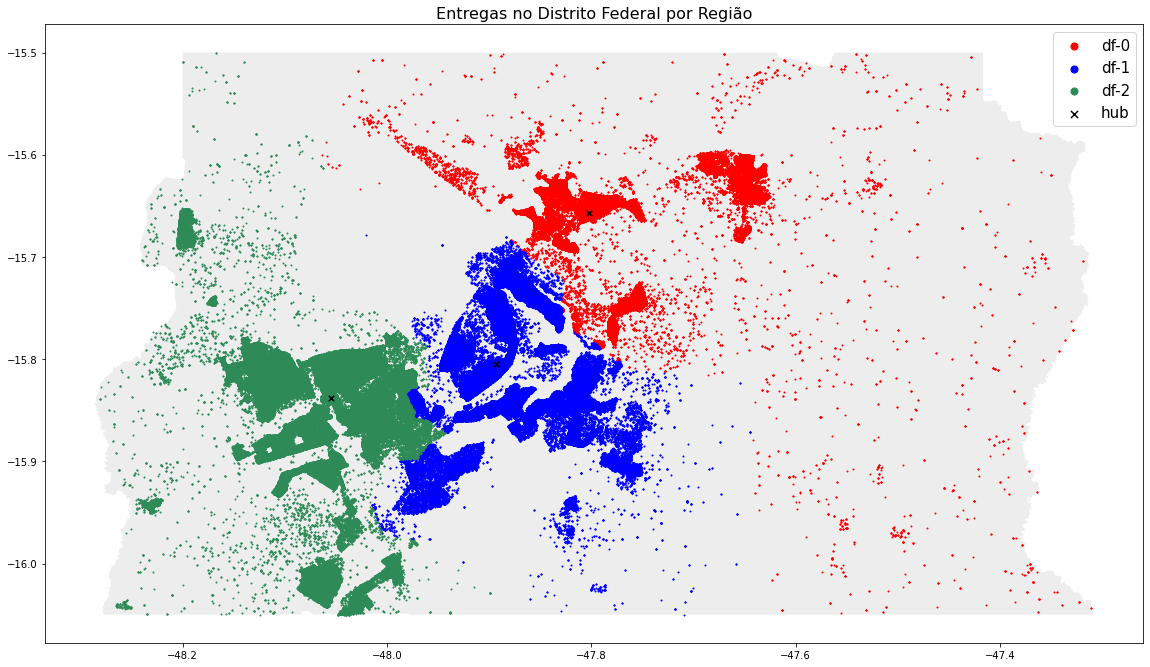

In [37]:
#renderizando a visualização
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])
plt.savefig('df.png')

É possível ver que a região df-0 possuem endereços de entrega muito distantes do hub e muito espalhados por uma larga região. A região df-1 é a com os endereços mais próximos do hub, em compensação a densidade de pontos é grande, e por isso essa região entrega para muito mais endereços do que a região df-0. A região df-2 se encontra em um meio termo: também possue uma alta densidade de endereços de entrega, comparável ao da região df-1 mas também possuem endereços espalhados com baixa densidade em uma região aparantemente rural.

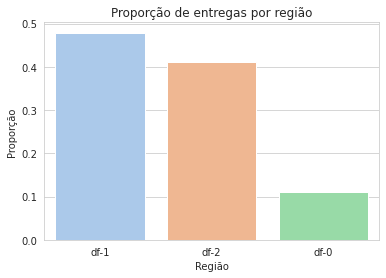

In [34]:
#verificando a quantidade de endereços em cada região
data = pd.DataFrame(delivery_final[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

A região df-0 abrange um número muito menor de endereços que as outras duas. Porém, como estes endereços estão muito mais espalhados por uma grande area, é compreensível que a empresa tenha optado por empregar a mesma capacidade veicular que nas demais regiões. Uma análise mais minuciosa, levando em conta também as distâncias e as rotas possíveis, é necessária para confirmar se essa escolha é a mais otimizada.
